In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [378]:
wines = pd.read_csv("../examples/ML/winequality-white.csv",delimiter=";")
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2040C710>,
      dtype=object)

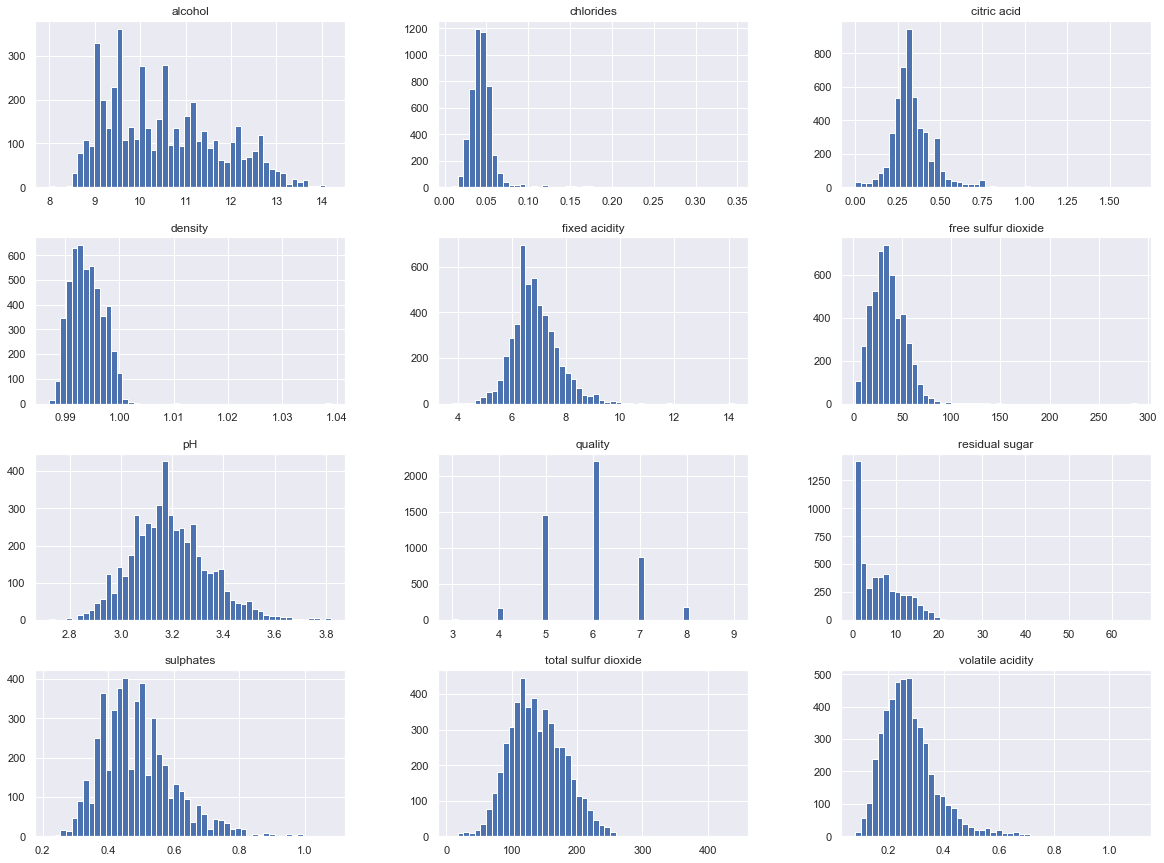

In [379]:
wines.hist(bins=50,figsize=(20,15))

It's pretty convennient that we don't have any categorical data. So we don't have to do any further transformations there.

In [380]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.2 KB


I plot the correlation in all the columns to see which have the most

In [381]:
cm = sns.light_palette("green",as_cmap=True)

wines.corr().style.background_gradient(cmap=cm)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1,-0.0226973,0.289181,0.0890207,0.0230856,-0.0493959,0.0910698,0.265331,-0.425858,-0.017143,-0.120881,-0.113663
volatile acidity,-0.0226973,1,-0.149472,0.0642861,0.0705116,-0.0970119,0.0892605,0.0271138,-0.0319154,-0.0357281,0.0677179,-0.194723
citric acid,0.289181,-0.149472,1,0.0942116,0.114364,0.0940772,0.121131,0.149503,-0.163748,0.0623309,-0.0757287,-0.00920909
residual sugar,0.0890207,0.0642861,0.0942116,1,0.0886845,0.299098,0.401439,0.838966,-0.194133,-0.0266644,-0.450631,-0.0975768
chlorides,0.0230856,0.0705116,0.114364,0.0886845,1,0.101392,0.19891,0.257211,-0.0904395,0.0167629,-0.360189,-0.209934
free sulfur dioxide,-0.0493959,-0.0970119,0.0940772,0.299098,0.101392,1,0.615501,0.29421,-0.000617796,0.0592172,-0.250104,0.00815807
total sulfur dioxide,0.0910698,0.0892605,0.121131,0.401439,0.19891,0.615501,1,0.529881,0.00232097,0.134562,-0.448892,-0.174737
density,0.265331,0.0271138,0.149503,0.838966,0.257211,0.29421,0.529881,1,-0.0935915,0.0744931,-0.780138,-0.307123
pH,-0.425858,-0.0319154,-0.163748,-0.194133,-0.0904395,-0.000617796,0.00232097,-0.0935915,1,0.155951,0.121432,0.0994272
sulphates,-0.017143,-0.0357281,0.0623309,-0.0266644,0.0167629,0.0592172,0.134562,0.0744931,0.155951,1,-0.0174328,0.0536779


As we can see *residual sugar* and *density* are strongly postive correlated. We might want to merge them or delete one. But as the dataset isn't that big I think we can keep both

We now split our data into test and training set using sklearn:

In [382]:
from sklearn.model_selection import train_test_split

In [383]:
train_set, test_set = train_test_split(wines,test_size=0.2,random_state=42)

In [384]:
train_no_quality = train_set.drop("quality",axis=1)
wine_labels = train_set["quality"].copy()

We see that the test-set is actually 20% of the whole dataset so that's correct

In [385]:
len(test_set)/len(wines)

0.2000816659861168

In [386]:
wines["sugar_density"] = wines["density"] / wines["residual sugar"]

In [387]:
wines.drop(columns="sugar_density",inplace=True)

As we don't have any missing data and no categorical data we just need to scale each column the same

In [388]:
from sklearn.preprocessing import StandardScaler

standard_wines = StandardScaler().fit_transform(train_no_quality)

In [389]:
from sklearn.linear_model import LinearRegression

In [390]:
lin_reg = LinearRegression()

In [391]:
print(train_no_quality.shape)
print(standard_wines.shape)
wine_labels.shape

(3918, 11)
(3918, 11)


(3918,)

In [392]:
lin_reg.fit(standard_wines,wine_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [393]:
some_data = train_no_quality.iloc[:5]
some_labels = wine_labels.iloc[:5]

some_data_prepared = StandardScaler().fit_transform(some_data)

In [394]:
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [6.63173922 5.42458883 5.83031677 5.87133775 5.59883213]
Labels: [6, 5, 6, 7, 5]


This already looks pretty promising the predictions and the labels are already pretty close. Let's compute the total error with a root mean_squared_error function

In [395]:
from sklearn.metrics import mean_squared_error

In [396]:
wine_predictions = lin_reg.predict(standard_wines)

We see the cost of the whole prediction is only 0.75 which is pretty good but we want it even closer to zero

In [397]:
cost = np.sqrt(mean_squared_error(wine_labels,wine_predictions))
cost

0.7502172818316429

###### Decision Tree

In [398]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(standard_wines,wine_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [399]:
tree_predictions = tree_reg.predict(standard_wines)

This is unbelievable the decisionTree can predict our data perfectly let's check if its  not overfitting

In [400]:
tree_cost = np.sqrt(mean_squared_error(wine_labels,tree_predictions))
tree_cost

0.0

Let's use Cross Validation to check our tree on different training sets

In [401]:
from sklearn.model_selection import cross_val_score

In [402]:
scores = cross_val_score(tree_reg,standard_wines,wine_labels,
                        scoring="neg_mean_squared_error",cv=10)

This looks like bad news it seems like our decision tree is actually worse than our standard linear regression

In [403]:
tree_cross_error = np.sqrt(-scores)
tree_cross_error.mean()

0.8665652013120928

###### Random Forests

In [404]:
from sklearn.ensemble import RandomForestRegressor

In [405]:
for_reg = RandomForestRegressor()
for_reg.fit(standard_wines,wine_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [406]:
forrest_prediction = for_reg.predict(standard_wines)

In [407]:
forest_score = cross_val_score(for_reg,standard_wines,wine_labels,
                              scoring="neg_mean_squared_error",cv=10)

In [408]:
forest_cross_error = np.sqrt(-forest_score).mean()
forest_cross_error

0.6230593456715485

###### SVM

In [409]:
from sklearn.svm import SVR

In [410]:
svr_fit = SVR(kernel="rbf",C=10).fit(standard_wines,wine_labels)

In [411]:
support_pred = svr_fit.predict(standard_wines)

In [412]:
svm_score = np.sqrt(-cross_val_score(svr_fit,standard_wines,wine_labels,
                              scoring="neg_mean_squared_error",cv=10))
svm_score.mean()

0.6955190893953251

I have tweaked several hyperparamaters on the svm model but the best I could get is 0.69. So let's fine tune our RandomForestsRegressor with a randomized search to get the best hyperparameters

In [413]:
from sklearn.model_selection import RandomizedSearchCV

In [414]:
new_random_forrests = RandomForestRegressor()

In [429]:
param = [
    {"n_estimators":[45,90,95],"max_features":[2,1,3]}
]

grid_search = RandomizedSearchCV(new_random_forrests,cv=5,param_distributions=param,
                                 scoring="neg_mean_squared_error", return_train_score=True)

In [430]:
with_attr = grid_search.fit(standard_wines,wine_labels)

C:\Users\Admin\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [431]:
with_attr.best_params_

{'n_estimators': 90, 'max_features': 2}

In [432]:
np.sqrt(sorted(-with_attr.cv_results_["mean_test_score"]))

array([0.62098865, 0.62115951, 0.62272519, 0.62449033, 0.62784081,
       0.62815455, 0.62988328, 0.63006491, 0.63317859])

Now that ive played with the hyperparameters its time to check how important each attribute is and if we could maybe drop one or two

In [419]:
feature_importance = grid_search.best_estimator_.feature_importances_

In [420]:
sorted(zip(feature_importance,train_no_quality.columns),reverse=True)

[(0.1710504932070254, 'alcohol'),
 (0.10760192557321417, 'volatile acidity'),
 (0.10643584066082473, 'density'),
 (0.10461840884811746, 'free sulfur dioxide'),
 (0.08303801058285486, 'total sulfur dioxide'),
 (0.07970699137362872, 'chlorides'),
 (0.07744392189714927, 'residual sugar'),
 (0.0720905233755775, 'pH'),
 (0.06913141273774553, 'citric acid'),
 (0.06635161915203426, 'fixed acidity'),
 (0.06253085259182802, 'sulphates')]

Sulphates and fixed acidity seem redundant lets see if our accuracy increases if we drop them

In [421]:
standard_new = StandardScaler().fit_transform(train_no_quality.drop(columns=["sulphates","fixed acidity"]))

In [422]:
standard_new.std()

1.0

In [423]:
#grid_wo_attr = grid_search.fit(standard_new,wine_labels)

In [424]:
#np.sqrt(sorted(-grid_wo_attr.cv_results_["mean_test_score"]))

Unfortanetly this didn't improve the model so we use the model with both attributes. I commented them out bc I was getting confused
###### Lets test our model on the test set

In [433]:
np.sqrt(sorted(-with_attr.cv_results_["mean_test_score"]))

array([0.62098865, 0.62115951, 0.62272519, 0.62449033, 0.62784081,
       0.62815455, 0.62988328, 0.63006491, 0.63317859])

In [435]:
final_model = with_attr.best_estimator_

In [436]:
test_predictions = test_set.drop("quality",axis=1)
test_labels = test_set["quality"].copy()

Standardize...

In [437]:
test_prepared = StandardScaler().fit_transform(test_predictions)

In [438]:
test_prepared.std()

1.0

In [439]:
final_prediction = final_model.predict(test_prepared)

Calculate Error

In [453]:
final_error = np.sqrt(mean_squared_error(test_labels,final_prediction))
final_error

0.601631589440706

Our model actually performed better on the new data than on the training set. We can now predict the wine quality based on it's ingredients using **final_model.predict()**